# Tutorial 3: Fixed dimension MCMC with Eryn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the third tutorial, we are going to learn how to use MCMC through `Eryn` to do our data analysis investigations. In this tutorial, we will stick with simple examples and simple signals (like in Tutorial 1). In later tutorials, we will use eryn with real GW signals. 

## Task 1: build your own basic MCMC

In order to better understand MCMC and `Eryn`, we are going to start by building our own MCMC algorithm for a simple problem. We will do this with a single-dimensional Gaussian likelihood centered on ($\mu=0$) and a unit standard deviation ($\sigma=1$) and a uniform prior. 

In [2]:
def log_like_gauss(x):
    return -0.5 * x ** 2 - 1/2 * np.log(2 * np.pi * 1.0) # 1.0 is sigma

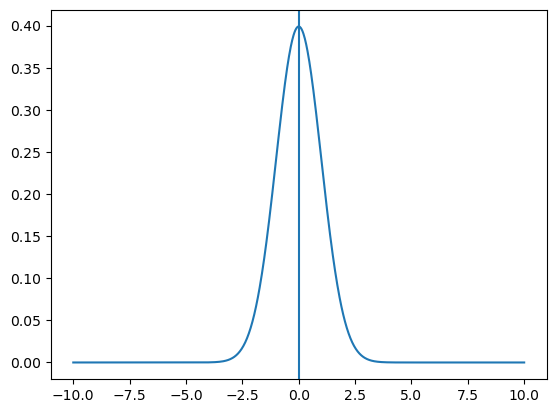

In [3]:
x_vals = np.linspace(-10.0, 10.0, 1000)
# notice the `exp` in there because we are working with the log of the likelihood.
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.axvline(0.0)

We are just going to write this into a simple loop. Gather your samples into the chain list.

In [4]:
num_steps = 100000

# get random starting point
current_point = np.random.uniform(-10.0, 10.0)
current_likelihood = log_like_gauss(current_point)
chain = []
for step in range(num_steps):
    # propose new point using a Gaussian distribution with standard deviation of 0.5
    # hint: use current + sigma * N() where N() is a draw from a normal distribution 
    # (np.random.randn)
    new_point = current_point + 0.5 * np.random.randn()

    # get new likelihood
    new_likelihood = log_like_gauss(new_point)

    # calculate the change in posterior
    # here we are using a uniform prior, so its value will not change, so for now do not
    # worry about the prior.
    delta_posterior = new_likelihood - current_likelihood  #  + (new_prior - old_prior)

    # accept or reject
    # if change in log posterior is greater than log(np.random.rand()), accept, else reject
    accept = delta_posterior > np.log(np.random.rand())

    if accept:
        current_point = new_point
        current_likelihood = new_likelihood

    chain.append(current_point)
    

Now plot the chain. You will notice that the beginnning requires a "burn in" phase. So, when calculating the posterior, you must remove this. There are ways to calculate how much burn in is appropriate, but we will not get into that here. 

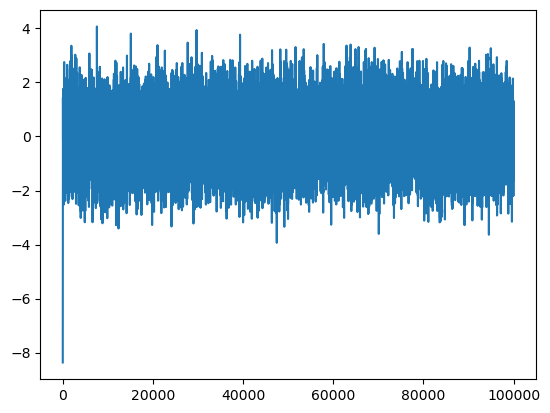

In [5]:
plt.plot(chain)

Plot the posterior distribution generated by the MCMC and compare it against the true Likelihood plot from above. Remember to set `density=True` when building the histogram.

If we take a step back here, we realize MCMC is really just a way to draw samples from a distribution. When the distribution is simple like this example, it will usually be available already with no need to run MCMC (like in scipy). However, in our area of work, the Likelihood distribution tends to be very difficult to deal with, which is why MCMC is so useful for us. To illustrate this, we will draw samples from the same distribution available in Numpy (`np.random.randn`).

(array([5.64604088e-05, 2.25841635e-04, 3.38762453e-04, 1.69381226e-03,
        3.33116412e-03, 6.04126374e-03, 9.76765072e-03, 2.03822076e-02,
        3.00933979e-02, 5.13789720e-02, 7.26080857e-02, 1.01572275e-01,
        1.33528867e-01, 1.71131499e-01, 2.22510471e-01, 2.66210827e-01,
        3.13242348e-01, 3.49038247e-01, 3.72412856e-01, 3.85398750e-01,
        3.90423727e-01, 3.75066496e-01, 3.50562678e-01, 3.13468190e-01,
        2.78067513e-01, 2.29398641e-01, 1.81520214e-01, 1.37481095e-01,
        9.92573987e-02, 7.43583584e-02, 5.09837491e-02, 3.39327057e-02,
        2.51813423e-02, 1.41151022e-02, 8.18675928e-03, 4.00868902e-03,
        2.37133717e-03, 1.35504981e-03, 4.51683270e-04, 2.82302044e-04]),
 array([-3.93393864e+00, -3.73714390e+00, -3.54034917e+00, -3.34355444e+00,
        -3.14675970e+00, -2.94996497e+00, -2.75317024e+00, -2.55637550e+00,
        -2.35958077e+00, -2.16278603e+00, -1.96599130e+00, -1.76919657e+00,
        -1.57240183e+00, -1.37560710e+00, -1.17881

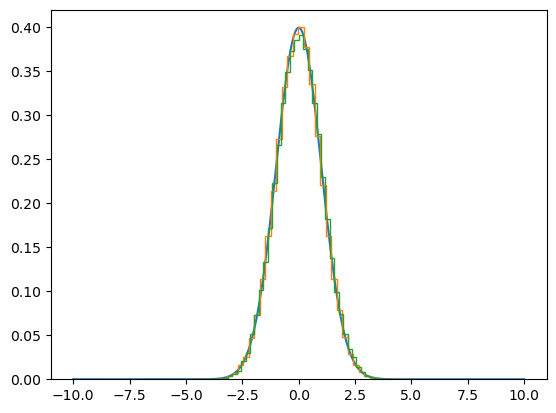

In [6]:
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.hist(np.random.randn(100000), bins=40, density=True, histtype="step")
plt.hist(chain[10000:], bins=40, density=True, histtype="step")

## Task 2: Use Eryn to reproduce the above result.

Now use the `EnsembleSampler` in `Eryn` to reproduce the above results. If you are struggling, look at the `Eryn` tutorial. For Eryn, you will need to define a prior. Use `uniform_dist` to create a simple uniform distribution. For this example, you only need to worry about the Ensemble Sampler keyword arguments. Leave those all as default values and only enter the arguments.

Useful documentation:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [State](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.State)
* [uniform_dist](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.uniform_dist)
* [ProbDistContainer](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.ProbDistContainer)

In [7]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

Initialize your sampler here. The prior initialization should take the form: `ProbDistContainer({0: prior distribution})`.

In [8]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, log_like_gauss, prior)

Now choose your starting point (one for each walker). You can draw from the prior or not. Just make sure to remove any burn in at the end. Then put the starting point into a `State` object. The key here is the start point should have shape `(1, nwalkers, 1, ndim)`. Here the two 1s are for temperatures (which we are not using right now) and the number of leaves or model count (this is for RJ). After this is complete, run the sampler.

Documentation:
* [run_mcmc](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler.run_mcmc)

In [9]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

In [10]:
end_point = sampler.run_mcmc(start_state, 10000, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:18<00:00, 547.81it/s]


Examine the output chains.

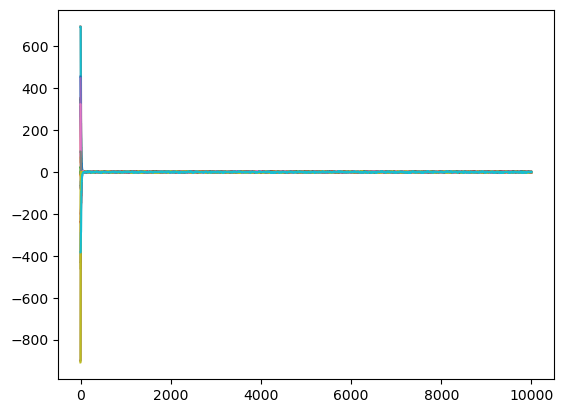

In [11]:
chain = sampler.get_chain()["model_0"]
for w in range(nwalkers):
    plt.plot(chain[:, 0, w, 0])

Compare your output chains to the injected Gaussian distribution. They should match. Make sure when you plot the histogram, you set `density=True`. 

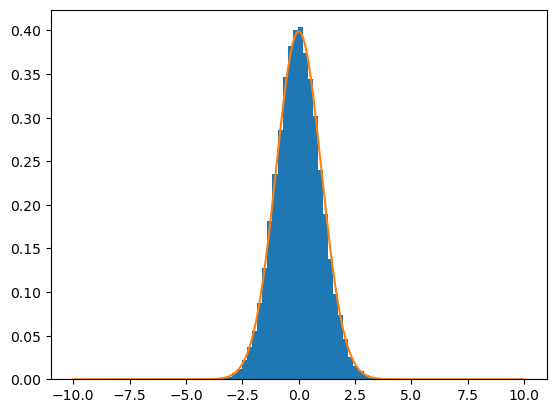

In [12]:
plt.hist(chain[1000:].flatten(), bins=40, density=True)
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

## Task 3: Parallel Tempering

Now we will add parallel tempering. In order to examine the effect of addering tempering, we are going to look at a 1D distribution with two Gaussian peaks with different weights. We have provided the log Likelihood function for this exercise. You just set the x limits to proper normalize the distribution.

Parallel tempering works by supressing the Log Likelihood in comparison to the log prior: `1/T * logL + logp`. This effect lowers the peaks making it easier for higher temperature chains to traverse a low-Likelihood portion of the Likelihood surface. This helps to properly sample distributions with multiple posterior modes. 

We will start by sampling without tempering to see how well that does. Then we will add tempering to see the improvement. 

In [14]:
from scipy.special import logsumexp

class LogLikeTwoGuass:
    def __init__(self, x_min: float, x_max: float):
        num_for_norm = 100000
        self.norm = 1.0
        x_vals = np.linspace(x_min, x_max, num_for_norm)
        y_vals = np.array([np.exp(self.log_like_two_gauss(x_tmp)) for x_tmp in x_vals])
        self.norm = np.trapz(y_vals, x=x_vals)
        
    def log_like_two_gauss(self, x):
        return logsumexp(np.array([(np.log(0.2) + -0.5 * (x - 50.0) ** 2), (np.log(0.8) + -0.5 * (x + 50.0) ** 2)]), axis=0) - np.log(self.norm)

In [15]:
like = LogLikeTwoGuass(-1000.0, 1000.0)

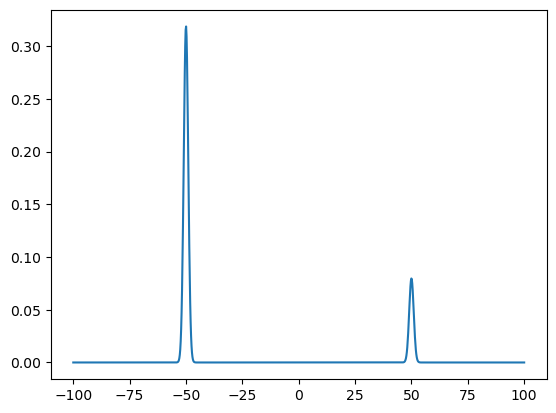

In [16]:
x_vals = np.linspace(-100.0, 100.0, 1000)
# notice the `exp` in there because we are working with the log of the likelihood.
plt.plot(x_vals, np.exp(like.log_like_two_gauss(x_vals)))
#plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))


Start with a non-tempered sampler. Run it and plot the histogram over the injected Likelihood. 

In [16]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, like.log_like_two_gauss, prior)

In [17]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)
sampler.run_mcmc(start_state, 10000, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 344.57it/s]


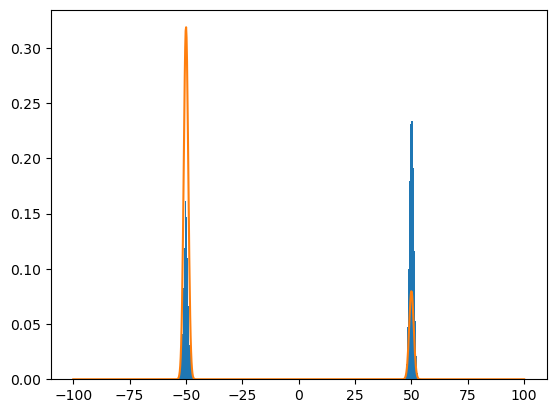

In [18]:
chain = sampler.get_chain()["model_0"][:, 0, :, 0]
plt.hist(chain[7000:].flatten(), bins=np.arange(-75., 75., 0.5), density=True)
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))

### Question

The plot should not look correct. Why do you think this is? When not using tempering, what determines the number of walkers inhabiting each peak?

Now add temperatures by providing `tempering_kwargs` kwarg to `EnsembleSampler.

Useful Documentation:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [TemperatureControl](https://mikekatz04.github.io/Eryn/html/user/temper.html#eryn.moves.tempering.TemperatureControl)

In [19]:
ntemps = 10
sampler_pt = EnsembleSampler(nwalkers, 1, like.log_like_two_gauss, prior, tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf))

Sample start points again from the prior with shape `(ntemps, nwalkers, 1, ndim)`. Then run the sampler.

In [20]:
start_point = prior.rvs(size=(ntemps, nwalkers, 1))
start_state = State(start_point)
sampler_pt.run_mcmc(start_state, 10000, progress=True)

100%|█████████████████████████████████████| 10000/10000 [02:08<00:00, 77.80it/s]


Plot the chains over the injection distribution.

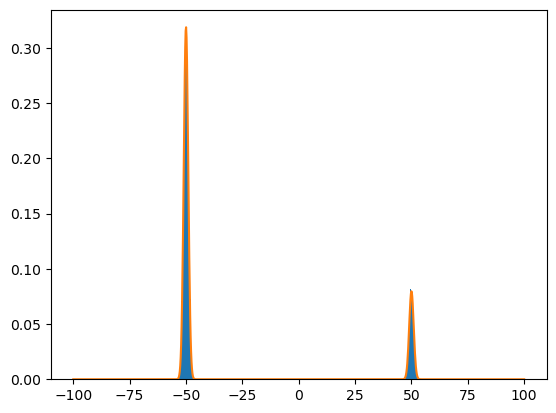

In [21]:
chain = sampler_pt.get_chain()["model_0"][:, 0, :, 0]
plt.hist(chain[1000:].flatten(), bins=np.arange(-75., 75., 0.5), density=True)
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))

Now the plots should match very weel. Can you describe the change that took place?

## Task 6: Add GWs!

Now we will add GW signals in the form of the simple Sinusoid we used in the first tutorial. We will start with the waveform function. Set up the `DataResidualArray` (inject whatever parameter you would like), `SensitivityMatrix`, and `AnalysisContainer`. Remember, we do not have a response on this signal, so the sensitivity curve should be `LISASens`. 

In [22]:
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import SensitivityMatrix, LISASens

We will add the waveform for you.

In [23]:
def sinusoidal_waveform(A: float, f0: float, phi0: float, t: np.ndarray, **kwargs) -> [np.ndarray, np.ndarray]:
    h1 = A * np.sin(2 * np.pi * (f0 * t) + phi0)
    h2 = A * np.cos(2 * np.pi * (f0 * t) + phi0)
    return [h1, h2]

Generate the injection data, input it into a `DataResidualArray`, load a `SensitivityMatrix`, and store everything in an `AnalysisContainer`, including the sinusoidal waveform generator. 

In [24]:
dt = 10.0
t_arr = np.arange(100000) * dt
data = DataResidualArray(sinusoidal_waveform(1e-21, 2e-3, np.pi / 3, t_arr), dt=dt)
sens_mat = SensitivityMatrix(data.f_arr, [LISASens, LISASens])
analysis = AnalysisContainer(data, sens_mat, signal_gen=sinusoidal_waveform)

/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:93: RuntimeWarning: divide by zero enco

Calculate the SNR of the injection. (`AnalysisContainer.calculate_signal_snr`)

In [25]:
analysis.calculate_signal_snr(1e-21, 2e-3, 0.0, t_arr)

(30.849156386054677, 15.424578193023095)

Biuld the prior distributions for the three parameters.

In [26]:
priors = ProbDistContainer({
    0: uniform_dist(9e-22, 3e-21),
    1: uniform_dist(1.5e-3, 2.5e-3),
    2: uniform_dist(0.0, 2 * np.pi)
})

Initialize the sampler. For the Likelihood function, you can use `AnalysisContainer.eryn_likelihood_function`. For  now, we will not use tempering. This generation scheme is not efficient in terms of the Likelihood evaluation time. So, we will just run this as a quick example. You can run it longer later on and/or parallelize it with Eryn's `pool` capabilities. This basic example we are using illustrates the need for fast waveform generation capabilities. 

In [17]:
ndim = 3
sampler = EnsembleSampler(
    nwalkers,
    ndim, 
    analysis.eryn_likelihood_function,
    priors,
    args=(t_arr,)
)

NameError: name 'EnsembleSampler' is not defined

Generate the start state and run the sampler. 

In [27]:
start_state = State(priors.rvs(size=(1, nwalkers, 1)))
sampler.run_mcmc(start_state, 100, progress=True)

You can examine the chains and/or Likelihood values if you want, but you will likely have to run it for longer to get any reasonable results. 

### Question

What types of things can we do to speed up this calculation? Translate this into the waveform environment. 

## Task 4: Calculate the evidence

Calculate the evidence for the single-peaked Gaussian distribution using thermodynamic integration from Eryn. Use 10 walkers and 50 temperatures to start. You can play with these numbers later and observe their effect on the measurement. Use the `burn` kwarg when running `run_mcmc`. **Important**: for the `tempering_kwargs` keyword argument for `EnsembleSampler`, you must add to the dictionary: `stop_adaptation=burn`. This will adapt the temperatures during burn in and then hold them fixed while recording samples. 

Useful documentation:
* [thermodynamic_integration_log_evidence](https://mikekatz04.github.io/Eryn/html/user/utils.html#eryn.utils.utility.thermodynamic_integration_log_evidence)

In [18]:
# imports
from eryn.utils.utility import thermodynamic_integration_log_evidence

Initialize the sampler. Run the MCMC.

In [31]:
nwalkers = 10
ntemps = 50
burn = 2000
sampler_pt_2 = EnsembleSampler(nwalkers, 1, log_like_gauss, prior, tempering_kwargs=dict(stop_adaptation=burn, ntemps=ntemps, Tmax=np.inf))

start_point = prior.rvs(size=(ntemps, nwalkers, 1))
start_state = State(start_point)
sampler_pt_2.run_mcmc(start_state, 10000, burn=burn, progress=True)


100%|█████████████████████████████████████| 10000/10000 [01:50<00:00, 90.40it/s]

(-16.388129049006988, 85.04235906548969)


1) Compute the average likelihood across all samples and walkers **within** each temperature chain.
2) Get the inverse temperatures (`betas`) out of the sampler backend and make sure they are the same over the entire run.
3) Calculate the evidence.

Useful Documentation:
* [thermodynamic_integration_log_evidence](https://mikekatz04.github.io/Eryn/html/user/utils.html#eryn.utils.utility.thermodynamic_integration_log_evidence)
* [Backend.get_log_like](https://mikekatz04.github.io/Eryn/html/user/backend.html#eryn.backends.Backend.get_log_like)
* [Backend.get_betas](https://mikekatz04.github.io/Eryn/html/user/backend.html#eryn.backends.Backend.get_betas)

In [ ]:
logl_avg = sampler_pt_2.get_log_like().mean(axis=(0, 2))
betas = sampler_pt_2.get_betas()[-1]
assert np.all(betas == sampler_pt_2.get_betas()[0])
logz = thermodynamic_integration_log_evidence(betas, logl_avg)
print(logz)

## Task 5: Model Selection

Perform model comparison between a Gaussian and Cauchy pulse using thermodynamic integration of the evidence.

Here are the pulse functions and the Likelhiood. We will assume each pulse has an amplitude and mean parameter. We set the standard deviation to be 1. 

In [19]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

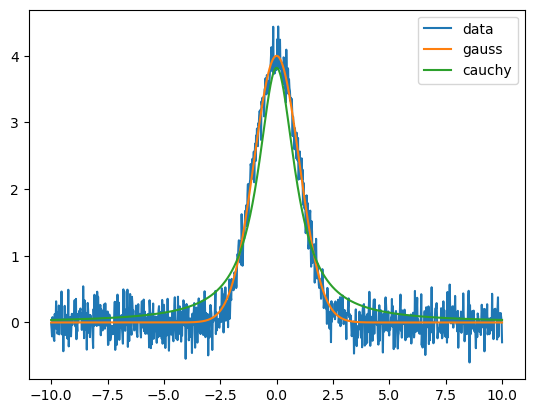

In [20]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 0.2
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

We need to run separate sampler objects for each model. 

The priors are identical really for the two models. The amplitude prior should span the injection values. The mean prior should span the domain of time.

Initialize the priors for each, the sampler for each, sample a start point for each, and run both samplers with the setup we used above. 

In [34]:
priors = {}
samplers = {}
burn = 1000
for name in ["gauss", "cauchy"]: 
    priors[name] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
})
    samplers[name] = EnsembleSampler(
        nwalkers,
        2,
        log_like_fn,
        priors,
        branch_names=[name],
        tempering_kwargs=dict(stop_adaptation=burn, ntemps=ntemps, Tmax=np.inf),
        args=(t_vals, data, sigma, name)
    )

    start_point = priors[name].rvs(size=(ntemps, nwalkers, 1))
    start_state = State({name: start_point})
    samplers[name].run_mcmc(start_state, 10000, burn=burn, progress=True)
    



100%|█████████████████████████████████████| 10000/10000 [12:39<00:00, 13.17it/s]


Repeat the calculation from above for both models. Then find Bayes Factor.

In [35]:
logz_out = {}
for name in ["gauss", "cauchy"]: 
    logls = samplers[name].get_log_like().mean(axis=(0, 2))
    betas = samplers[name].get_betas()
    assert np.all(betas[-1] == betas[0])
    logz, dlogz = thermodynamic_integration_log_evidence(betas[0], logls)
    print(name, logz, dlogz)
    logz_out[name] = logz

print("2log(Bayes Factor):", 2 * (logz_out["gauss"] - logz_out["cauchy"]))

gauss -561.126622384045 38.3733023285597
cauchy -1107.1794096124177 32.05485411995937
2log(Bayes Factor): 1092.1055744567452


### Question

If we change the noise, what effect will this have on our results?